<a href="https://colab.research.google.com/github/miloszpiechota/AI-Systems/blob/main/AppliancesEnergyPredictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Kolokwium 24.04.2025: Miłosz Piechota 97702

1. Dane z pliku energydata_complete.csv są ładowane do ramki danych df
2. Usunięcie niepotrzebnych kolumn: date (Modele LSTM i tak zakładają porządek czasowy danych ), rv1, rv2(losowe zmienne duplikaty), lights (zuzycie swiatła w budynku).
3. Sprawdzenie, czy nie ma brakujących danych.
4. Usunięcie kolumn o niskiej wariancji
5. Usunięcie cech o wysokiej korelacji
6. Skalowanie danych za pomocą standaryzacji StandarScaler
7. Redukcja wymiarów PCA
8. Dane są przekształcane w sekwencje tygodniowe (window_size = 1008) jako dane wejściowe do LSTM. Dane w zbiorze są zbierane co 10 min, w ciągu 1 h jest 60/10 = 6 próbek, doba to 24*6 = 144 próbek więc 7 dni to 7*144 = 1008 próbek
9. Celem jest predykcja wartości T5 na jeden dzień (144 kroki) do przodu
10. Dane są dzielone na zbiór treningowy i testowy (80/20) bez mieszania (ważne dla szeregów czasowych)
11. Model 1: LSTM(8) + Dropout(0.1)
Model 2: LSTM(16) + Dropout(0.2)
Model 3: LSTM(32) + Dropout(0.3)
Wszystkie kończą się warstwą Dense(1) dla predykcji pojedynczej wartości
12. Trenowanie modeli z epochs 3
13. Rysowanie wykresów strat i Dla pierwszych 200 kroków testowych porównywane są predykcje z rzeczywistymi wartościami T5, Obliczany jest błąd MSE (średni błąd kwadratowy).

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/3
105/105 ━━━━━━━━━━━━━━━━━━━━ 57s 522ms/step - loss: 4.4032 - val_loss: 1.8826
Epoch 2/3
105/105 ━━━━━━━━━━━━━━━━━━━━ 66s 365ms/step - loss: 2.1012 - val_loss: 1.0582
Epoch 3/3
105/105 ━━━━━━━━━━━━━━━━━━━━ 42s 371ms/step - loss: 1.2196 - val_loss: 0.9014
Epoch 1/3
105/105 ━━━━━━━━━━━━━━━━━━━━ 41s 367ms/step - loss: 3.6135 - val_loss: 0.9993
Epoch 2/3
105/105 ━━━━━━━━━━━━━━━━━━━━ 41s 362ms/step - loss: 1.0040 - val_loss: 0.7102
Epoch 3/3
105/105 ━━━━━━━━━━━━━━━━━━━━ 41s 366ms/step - loss: 0.6556 - val_loss: 0.6299
Epoch 1/3
105/105 ━━━━━━━━━━━━━━━━━━━━ 58s 528ms/step - loss: 3.0973 - val_loss: 0.5897
Epoch 2/3
105/105 ━━━━━━━━━━━━━━━━━━━━ 80s 514ms/step - loss: 0.6223 - val_loss: 0.5270
Epoch 3/3
105/105 ━━━━━━━━━━━━━━━━━━━━ 82s 518ms/step - loss: 0.5085 - val_loss: 0.4080


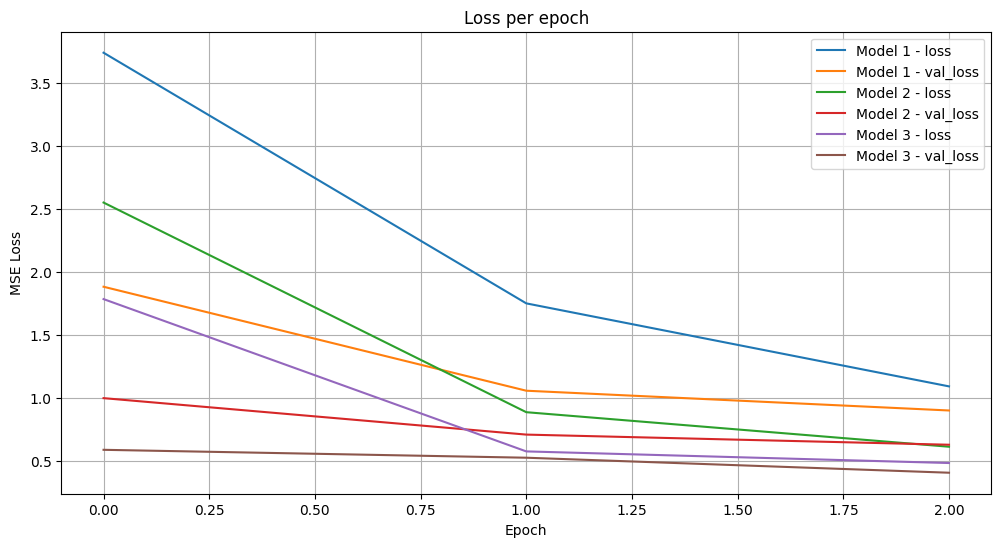

117/117 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step
Model 1: MSE = 18.0615


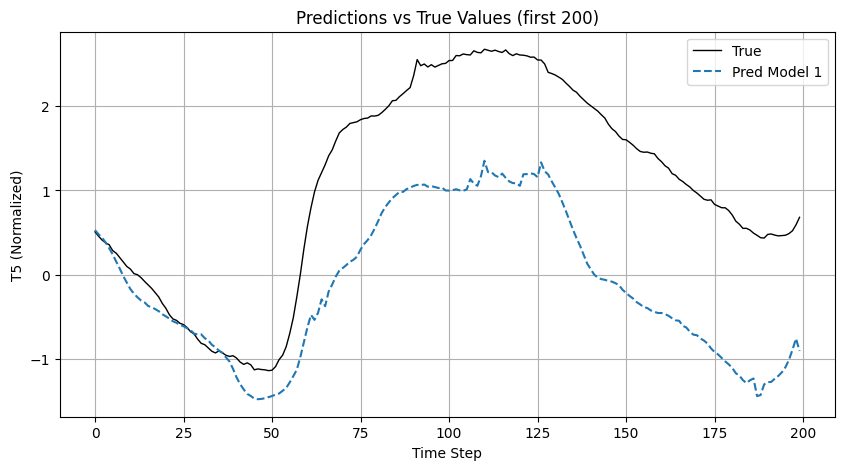

117/117 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step
Model 2: MSE = 17.6932


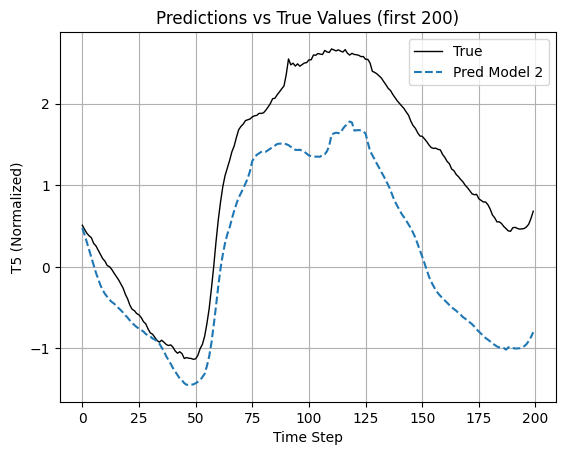

117/117 ━━━━━━━━━━━━━━━━━━━━ 12s 101ms/step
Model 3: MSE = 13.2347


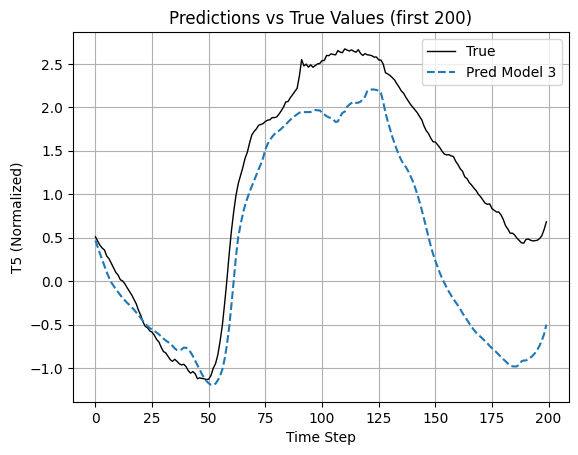

In [6]:
# --- [1] Importy i wczytanie danych ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Wczytanie danych
df = pd.read_csv("energydata_complete.csv")

# --- [2] Czyszczenie danych ---
df.drop(columns=["date", "rv1", "rv2", "lights"], inplace=True)

# Sprawdzenie brakujących danych
assert df.isnull().sum().sum() == 0, "Znaleziono brakujące dane!"

# --- [3] Usuwanie kolumn o niskiej wariancji ---
selector = VarianceThreshold(threshold=0.01)
df_reduced = pd.DataFrame(selector.fit_transform(df), columns=df.columns[selector.get_support()])

# --- [4] Usuwanie wysoko skorelowanych cech ---
corr_matrix = df_reduced.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
df_reduced.drop(columns=to_drop, inplace=True)

# --- [5] Skalowanie danych ---
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_reduced), columns=df_reduced.columns)

# --- [6] PCA ---
pca = PCA(n_components=0.95)
df_pca = pd.DataFrame(pca.fit_transform(df_scaled))

# --- [7] Przygotowanie danych do LSTM ---
def create_sequences(data, target_idx, window_size=1008):
    X, y = [], []
    for i in range(len(data) - window_size - 144):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size+143, target_idx])
    return np.array(X), np.array(y)

X, y = create_sequences(df_pca.values, target_idx=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# --- [8] Budowa modeli ---
def build_model_1():
    model = Sequential([
        LSTM(8, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
        Dropout(0.1),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_model_2():
    model = Sequential([
        LSTM(16, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_model_3():
    model = Sequential([
        LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
        Dropout(0.3),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

models = [build_model_1(), build_model_2(), build_model_3()]
history_list = []

for model in models:
    history = model.fit(X_train, y_train, validation_split=0.1, epochs=3, batch_size=128,
                        callbacks=[EarlyStopping(patience=2)], verbose=1)
    history_list.append(history)

# --- [9] Ewaluacja modeli i wykresy ---
plt.figure(figsize=(12, 6))
for i, (model, history) in enumerate(zip(models, history_list)):
    plt.plot(history.history['loss'], label=f'Model {i+1} - loss')
    plt.plot(history.history['val_loss'], label=f'Model {i+1} - val_loss')
plt.title('Loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
for i, model in enumerate(models):
    y_pred = model.predict(X_test)
    plt.plot(y_test[:200], label='True', color='black', linewidth=1)
    plt.plot(y_pred[:200], label=f'Pred Model {i+1}', linestyle='--')
    mse = mean_squared_error(y_test, y_pred)
    print(f"Model {i+1}: MSE = {mse:.4f}")
    plt.title('Predictions vs True Values (first 200)')
    plt.xlabel('Time Step')
    plt.ylabel('T5 (Normalized)')
    plt.legend()
    plt.grid(True)
    plt.show()

Wnioski z wykresu strat (Loss per epoch)
Model 3 (największa liczba neuronów LSTM — 32) osiąga najniższe wartości strat (loss i val_loss) już od pierwszej epoki, co może oznaczać że

lepiej sie uczy żłożoności czasowej, może mieć większą dokładność w prognozowaniu

Model 1 (najmniejszy — 8 neuronów LSTM) ma najwyższe wartości strat co niestety oznacza, że jego zdolność do uchwycenia dynamiki danych jest ograniczona.

Model 2 to sredni model, ale jego val_loss jest stabilne i dość niskie, co sugeruje dobrą generalizację.

Brak overfittingu bo linie loss i val_loss są do siebie zbliżone i malejące.



Wnioski z wykresu predykcji (Predictions vs True Values)

🔵 Model 1 (8 jednostek LSTM)
Zbyt prosty model — zbyt mała liczba neuronów ogranicza zdolność do uchwycenia dynamiki danych.

🟠 Model 2 (16 jednostek LSTM)
Model wydaje się lepszy niz 1 Model ale nie tak dobry jak 3 Model

🟢 Model 3 (32 jednostki LSTM)
Model 3 działa najlepiej — ma największą zdolność do uczenia się złożonych wzorców czasowych. Dodatkowo MSE czyli średni błąd kwadratowy jest najniższy bo ok. 13 czyli przewidywane wartości mogą być bliżej rzeczywistych